In [2]:
options(repr.plot.width=4, repr.plot.height=3)
require(pheatmap)
require(data.table)
require(tidyverse)

## 1. load data

In [3]:
dat.pro_ps.wd<- fread("../dat/1901/alpha_beta.promoter.long_100bin_transcripts_ps_smoothed_dy_varible.txt")%>%
    group_by(celltype)%>%spread(key = bin,value = percent_open)

head(dat.pro_ps.wd)
tail(dat.pro_ps.wd)
dim(dat.pro_ps.wd)
table(dat.pro_ps.wd$celltype)

gene_tr.idx,celltype,1,2,3,4,5,6,7,8,⋯,91,92,93,94,95,96,97,98,99,100
AAGAB_42733,alpha,3.8641661,4.4568743,5.0314140,5.5876162,6.1253120,6.6443324,7.144508,7.6256709,⋯,20.241210,21.036159,21.855849,22.700389,23.569889,24.464459,25.384207,26.329243,27.299677,28.295618
AASS_118936,beta,30.8721694,29.4504937,28.0715504,26.7361415,25.4450690,24.1991349,22.999141,21.8458900,⋯,15.190347,15.354458,15.528586,15.712148,15.904558,16.105233,16.313587,16.529038,16.751000,16.978890
ABCB4_117176,beta,16.8248207,15.9353944,15.0706113,14.2310510,13.4172931,12.6299171,11.869503,11.1366292,⋯,3.198395,3.182714,3.166231,3.148893,3.130644,3.111429,3.091192,3.069879,3.047434,3.023803
ABCB6_81071,beta,9.2829428,9.0544307,8.8336893,8.6206393,8.4152013,8.2172962,8.026844,7.8437668,⋯,13.433810,13.993902,14.577549,15.184122,15.812987,16.463513,17.135068,17.827020,18.538736,19.269587
ABCB9_32864,alpha,0.4323812,0.4150176,0.3984103,0.3825513,0.3674321,0.3530444,0.339380,0.3264305,⋯,4.610496,4.947564,5.297280,5.659454,6.033893,6.420405,6.818797,7.228878,7.650455,8.083337
ABCB9_32864,beta,7.7690195,7.2124705,6.6725025,6.1497342,5.6447847,5.1582726,4.690817,4.2430361,⋯,3.143808,3.280719,3.421437,3.565924,3.714144,3.866056,4.021624,4.180810,4.343576,4.509884


gene_tr.idx,celltype,1,2,3,4,5,6,7,8,⋯,91,92,93,94,95,96,97,98,99,100
ZSCAN5A_73073,beta,3.9704991,3.9396654,3.9113757,3.885237,3.8608545,3.8378363,3.8157885,3.7943178,⋯,8.095005,8.090843,8.086262,8.080977,8.074698,8.067141,8.058016,8.047038,8.033918,8.018371
ZSWIM2_79591,beta,28.4467168,27.3249049,26.2329936,25.171964,24.1427961,23.1464716,22.1839709,21.2562750,⋯,7.052941,7.144655,7.243188,7.348604,7.460966,7.580338,7.706783,7.840366,7.981148,8.129196
ZSWIM7_53953,alpha,20.4340939,19.8208247,19.2237919,18.643501,18.0804583,17.5351688,17.0081383,16.4998726,⋯,25.155638,26.490371,27.878573,29.319195,30.811189,32.353506,33.945097,35.584912,37.271903,39.005021
ZUFSP_112980,beta,19.2490226,18.3035074,17.3845624,16.493199,15.6304287,14.7972630,13.9947135,13.2237918,⋯,9.367259,9.716468,10.076786,10.448185,10.830640,11.224124,11.628609,12.044070,12.470480,12.907812
ZZEF1_52563,beta,0.1992746,0.2273509,0.2543777,0.280261,0.3049068,0.3282211,0.3501098,0.3704791,⋯,1.372181,1.454360,1.539635,1.627949,1.719245,1.813465,1.910554,2.010453,2.113105,2.218453
ZZZ3_5178,alpha,12.6591865,13.0673987,13.4613818,13.840516,14.2041818,14.5517591,14.8826283,15.1961696,⋯,34.542945,36.055159,37.624589,39.250229,40.931074,42.666119,44.454359,46.294789,48.186402,50.128195


[1] 2330  102


alpha  beta 
 1107  1223 

## 2. updated cluster 
[QuickR](https://www.statmethods.net/advstats/cluster.html) introduces the following methods categories:
1. Partitioning based methods or Centroid-based clustering: `kmeans`, `pam`
2. Hierarchical Agglomerative: `hclust`, `pvclust`
3. Model based: `mclust`
4. Density-based: [`DBSCAN`](https://en.wikipedia.org/wiki/DBSCAN)

More complete intro can be found [cluster analysis@WIKI](https://en.wikipedia.org/wiki/Cluster_analysis)
Also they introduced:
1. cluster compare: `fpc::cluster.stats`

Because the goal is to find dynamical patterns, I would like to choose 1. (i.e. kmeans or pam)


In [4]:
require(fpc)
dat.sub <- dat.pro_ps.wd%>%
    as.data.frame()%>%
    filter(celltype=='alpha')%>%
    column_to_rownames("gene_tr.idx")%>%
    select(-celltype)

Loading required package: fpc


### 2.1 filter max percent_open < 10% 

In [5]:
t(quantile(apply(dat.sub,1,max),probs = c(0,.05,.1,.25,.5,.75,.9,.95,1))) 
# filter on 10
tr.keep <- apply(dat.sub,1,max)>=10
table(tr.keep)
dat.sub.2 <- dat.sub[tr.keep,]

0%,5%,10%,25%,50%,75%,90%,95%,100%
1.982368,8.902002,12.98801,19.0262,26.70623,35.65397,43.81585,49.82674,75.00824


tr.keep
FALSE  TRUE 
   70  1037 

### 2.2 filter bottom < 5% 

tr.keep
FALSE  TRUE 
   70  1037 

2  clusters  0.4034753 
3  clusters  0.2904992 
4  clusters  0.3220902 
5  clusters  0.2655717 
6  clusters  0.2666618 
7  clusters  0.2202571 
8  clusters  0.2293574 
9  clusters  0.2402626 
10  clusters  0.2353361 



  1   2 
467 570 

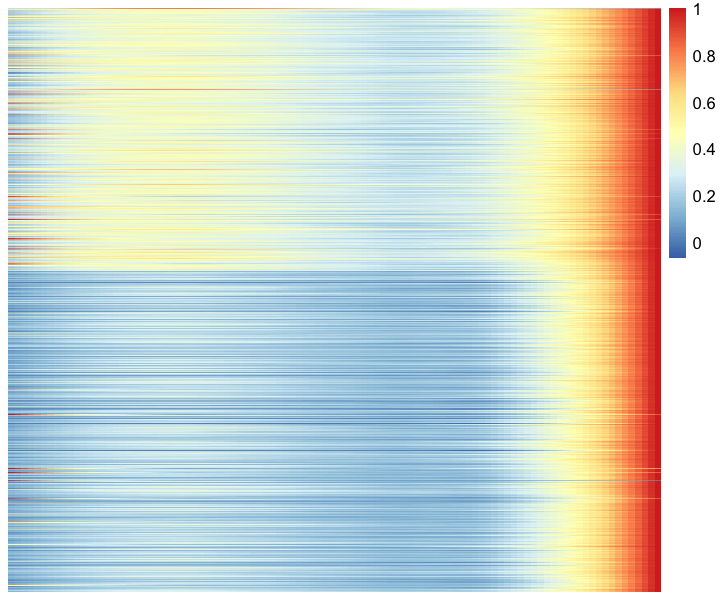

In [11]:
tr.keep <- apply(dat.sub,1,max)>=10
table(tr.keep)
dat.sub.2 <- dat.sub[tr.keep,]
dat.sub.2.scale <- t(apply(dat.sub.2,1,function(x) x/max(x)))
pk.scale<- pamk(dat.sub.2.scale,critout=T)
table(pk.scale$pamobject$clustering)
                           
pheatmap(dat.sub.2.scale[order(pk.scale$pamobject$clustering),],
         scale="none",cluster_rows = F,cluster_cols = F,
         show_rownames = F,show_colnames = F)
                           

### Subclustering 

2  clusters  0.4172202 
3  clusters  0.270258 
4  clusters  0.2446158 
5  clusters  0.2474358 
6  clusters  0.2455643 
7  clusters  0.2200187 
8  clusters  0.2167494 
9  clusters  0.2313902 
10  clusters  0.2393038 

  1   2 
351 116 
2  clusters  0.3856607 
3  clusters  0.2617983 
4  clusters  0.2691984 
5  clusters  0.2920316 
6  clusters  0.254617 
7  clusters  0.2566641 
8  clusters  0.2433321 
9  clusters  0.2338579 
10  clusters  0.196871 

  1   2 
356 214 


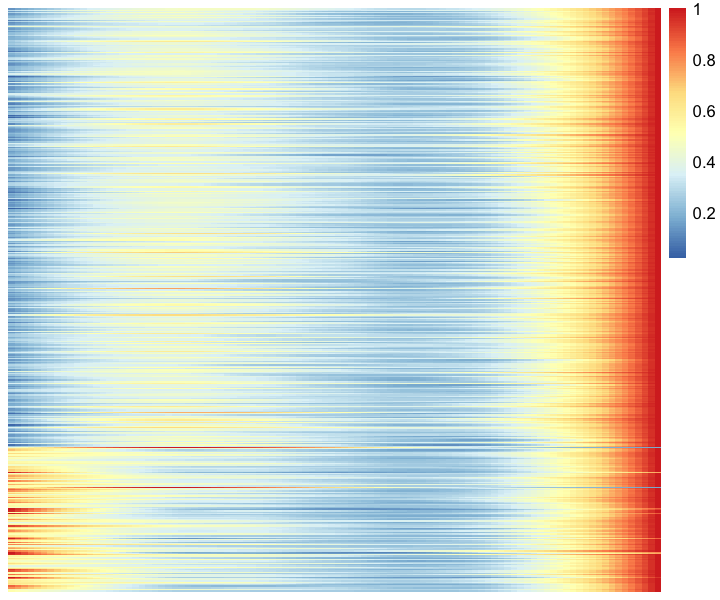

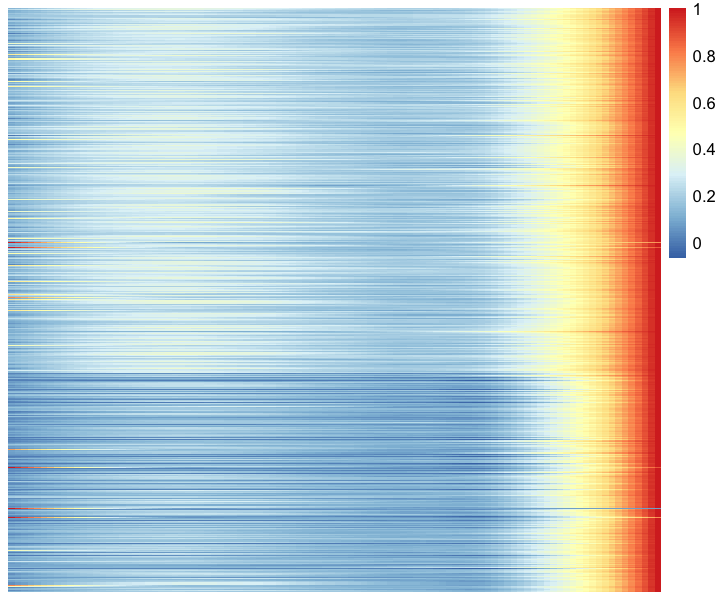

In [13]:
pk.scale.2 <- list()
dat.sub.2.scale.1 <- list()
for(i in 1:2){
    #cat(paste0("For Cluster ",i,"\n"))
    dat.sub.2.scale.1[[i]] <- dat.sub.2.scale[pk.scale$pamobject$clustering==i,]
    pk.scale.2[[i]]<- pamk(dat.sub.2.scale.1[[i]],critout=T)
    print(table(pk.scale.2[[i]]$pamobject$clustering))
    pheatmap(dat.sub.2.scale.1[[i]][order(pk.scale.2[[i]]$pamobject$clustering),],
         border_color = NA,scale="none",cluster_rows = F,cluster_cols = F,
         show_rownames = F,show_colnames = F)
}


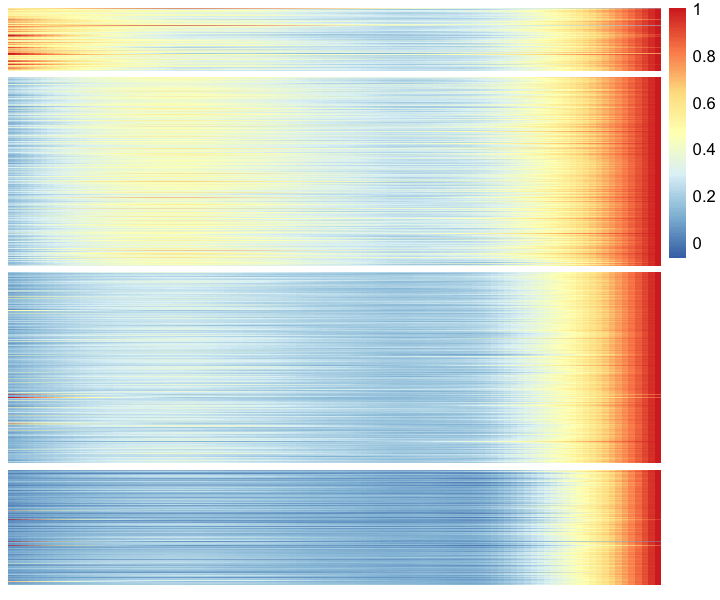

In [16]:
# 
a=(pk.scale.2[[1]]$pamobject$clustering)
b1=ifelse(a==1,2,1)
names(b1)=names(a)

a=(pk.scale.2[[2]]$pamobject$clustering)
b2=ifelse(a==1,3,4)
names(b2)=names(a)




final.ord = c(b1,b2)


options(repr.plot.width=6, repr.plot.height=5)

pheatmap(dat.sub.2.scale[names(final.ord)[order(final.ord)],],
         gaps_row = as.numeric(cumsum(table(final.ord))),
         scale="none",cluster_rows = F,cluster_cols = F,
         show_rownames = F,show_colnames = F)

In [17]:
table(final.ord)

final.ord
  1   2   3   4 
116 351 356 214 

In [19]:
pk.list<-sapply(1:4,function(x)
        unique(unlist(sapply(names(which(final.ord==x)), function(y) 
            unlist(strsplit(y,split = "_"))[1]))))
str(pk.list)

## go enrich                             
require(enrichR)
dbs <- listEnrichrDbs()                 
pk.list.gene.enrichr <- lapply(pk.list,function(x) 
    enrichr(x, c("GO_Biological_Process_2018"))$GO_Biological_Process_2018)
                             

List of 4
 $ : chr [1:115] "ABCC8" "AC020922.1" "ADAM11" "AKT1S1" ...
 $ : chr [1:350] "AAGAB" "ABCD3" "ABHD6" "ACBD6" ...
 $ : chr [1:355] "ABCF2" "AC103801.2" "ACAD10" "ACAP1" ...
 $ : chr [1:212] "ABHD2" "ACBD4" "ACHE" "ACTB" ...
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2018... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2018... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2018... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2018... Done.
Parsing results... Done.


In [20]:
head(pk.list.gene.enrichr[[1]]%>%
    separate(Overlap,into = c("n.hit","n.tot"),sep = "/",remove = F,convert = T)%>%
    filter(n.tot<=100)%>%arrange(Adjusted.P.value))
head(pk.list.gene.enrichr[[2]]%>%
    separate(Overlap,into = c("n.hit","n.tot"),sep = "/",remove = F,convert = T)%>%
    filter(n.tot<=100)%>%arrange(Adjusted.P.value))
head(pk.list.gene.enrichr[[3]]%>%
    separate(Overlap,into = c("n.hit","n.tot"),sep = "/",remove = F,convert = T)%>%
    filter(n.tot<=100)%>%arrange(Adjusted.P.value))
head(pk.list.gene.enrichr[[4]]%>%
    separate(Overlap,into = c("n.hit","n.tot"),sep = "/",remove = F,convert = T)%>%
    filter(n.tot<=100)%>%arrange(Adjusted.P.value))



Term,Overlap,n.hit,n.tot,P.value,Adjusted.P.value,Old.P.value,Old.Adjusted.P.value,Z.score,Combined.Score,Genes
mRNA 3'-end processing (GO:0031124),5/75,5,75,7.212211e-05,0.06144804,0.0001040482,0.08864904,-1.399044,13.342893,CPSF6;SRSF2;CASC3;SRSF6;SRRM1
mRNA metabolic process (GO:0016071),5/98,5,98,2.555271e-04,0.07256970,0.0003410659,0.09686273,-1.680045,13.897637,CPSF6;SRSF2;RNASE4;HIPK3;HNRNPA0
RNA 3'-end processing (GO:0031123),4/62,4,62,4.474936e-04,0.09531613,0.0005982978,0.12743744,-1.310989,10.110150,SRSF2;CASC3;SRSF6;SRRM1
termination of RNA polymerase II transcription (GO:0006369),4/69,4,69,6.724079e-04,0.11457831,0.0008759302,0.14925851,-1.338379,9.776388,SRSF2;CASC3;SRSF6;SRRM1
heterochromatin organization (GO:0070828),2/10,2,10,1.431147e-03,0.14842943,0.0021523061,0.19286346,-2.485366,16.277358,HP1BP3;SNAI1
RNA transport (GO:0050658),4/81,4,81,1.227457e-03,0.14842943,0.0015451425,0.18806592,-1.717337,11.510987,SRSF2;CASC3;SRSF6;SRRM1


Term,Overlap,n.hit,n.tot,P.value,Adjusted.P.value,Old.P.value,Old.Adjusted.P.value,Z.score,Combined.Score,Genes
regulation of cytokinesis (GO:0032465),10/78,10,78,1.037606e-06,0.0008861152,2.495332e-06,0.002131014,-2.243221,30.90843,PRC1;VPS4A;KIF13A;KLHL21;PIN1;MYO19;CALM2;RAB11A;RAB11FIP4;GIT1
regulation of cell cycle process (GO:0010564),11/91,11,91,5.469439e-07,0.0008861152,1.322407e-06,0.002131014,-1.554256,22.41069,TIPIN;SPAG5;PRC1;KIF13A;KLHL21;PIN1;MYO19;CALM2;RAB11A;RAB11FIP4;GIT1
regulation of cell division (GO:0051302),9/66,9,66,2.136822e-06,0.0012165642,5.073272e-06,0.002888383,-2.289068,29.88651,PRC1;KIF13A;KLHL21;PIN1;MYO19;CALM2;RAB11A;RAB11FIP4;GIT1
mitotic sister chromatid segregation (GO:0000070),8/83,8,83,1.022809e-04,0.0436739425,1.631145e-04,0.069649903,-1.368569,12.57412,SPAG5;PAPD7;PRC1;BOD1;VPS4A;KLHL22;PDS5A;RAB11A
regulation of early endosome to late endosome transport (GO:2000641),4/18,4,18,2.323196e-04,0.0793603688,4.784237e-04,0.163429537,-2.268096,18.97806,SNX3;MAP2K1;RDX;PTPN23
regulation of cellular protein localization (GO:1903827),4/26,4,26,1.016371e-03,0.2063567366,1.610220e-03,0.305583946,-2.562748,17.66122,PIN1;ATP13A2;RAB11FIP5;NDEL1


Term,Overlap,n.hit,n.tot,P.value,Adjusted.P.value,Old.P.value,Old.Adjusted.P.value,Z.score,Combined.Score,Genes
protein K63-linked ubiquitination (GO:0070534),5/38,5,38,0.0005312745,0.0932918,0.001008767,0.1650002,-1.500298,11.31259,ITCH;UBE2G1;STUB1;UBE2V1;RNF4
spliceosomal complex assembly (GO:0000245),5/42,5,42,0.0008496821,0.1147724,0.001516193,0.2048027,-1.466433,10.36863,SRPK2;SF3A2;CELF1;SRSF1;CRNKL1
regulation of hippo signaling (GO:0035330),3/12,3,12,0.0010830242,0.1358422,0.002245466,0.2778226,-2.847249,19.44101,NEK8;WWC3;NF2
multivesicular body assembly (GO:0036258),4/31,4,31,0.0021027522,0.1943386,0.003485061,0.3220930,-1.635805,10.08394,HGS;IST1;VPS37A;STAM
multivesicular body organization (GO:0036257),4/32,4,32,0.0023699246,0.1981708,0.003865974,0.3232690,-1.596662,9.65166,HGS;IST1;VPS37A;STAM
endodermal cell differentiation (GO:0035987),4/33,4,33,0.0026595532,0.2030511,0.004274118,0.3263196,-1.700924,10.08579,SETD2;ITGB5;PAF1;RTF1


Term,Overlap,n.hit,n.tot,P.value,Adjusted.P.value,Old.P.value,Old.Adjusted.P.value,Z.score,Combined.Score,Genes
positive regulation of cellular metabolic process (GO:0031325),7/93,7,93,5.964492e-05,0.07568941,9.730432e-05,0.1234792,-1.550675,15.08357,PRELID1;ANXA2;TBC1D5;ECE1;GRB2;INHBA;KLF4
negative regulation of mitotic cell cycle phase transition (GO:1901991),6/80,6,80,2.067780e-04,0.13120062,3.154975e-04,0.2001831,-1.580806,13.41135,RBL2;PSMD4;UBB;PSMB3;KLF4;PSMA7
"establishment of mitochondrion localization, microtubule-mediated (GO:0034643)",2/7,2,7,2.267618e-03,0.16565493,3.893313e-03,0.2555232,-3.464516,21.09553,RHOT2;UBB
peroxisome proliferator activated receptor signaling pathway (GO:0035357),2/8,2,8,3.002414e-03,0.16565493,4.832590e-03,0.2555232,-3.074350,17.85687,RXRA;ALOXE3
negative regulation of RIG-I signaling pathway (GO:0039536),2/8,2,8,3.002414e-03,0.16565493,4.832590e-03,0.2555232,-3.021152,17.54788,SEC14L1;GPATCH3
retrograde axonal transport (GO:0008090),2/8,2,8,3.002414e-03,0.16565493,4.832590e-03,0.2555232,-2.726872,15.83860,DST;PAFAH1B1


### subsubclustering

2  clusters  0.2891486 
3  clusters  0.2474679 
4  clusters  0.2656937 
5  clusters  0.24648 
6  clusters  0.2040334 
7  clusters  0.2099982 
8  clusters  0.2087448 
9  clusters  0.2088398 
10  clusters  0.1779312 

  1   2 
185 166 
2  clusters  0.2931836 
3  clusters  0.1935113 
4  clusters  0.2489741 
5  clusters  0.209595 
6  clusters  0.2567707 
7  clusters  0.2754301 
8  clusters  0.2451076 
9  clusters  0.2403077 
10  clusters  0.2479428 

 1  2 
47 69 


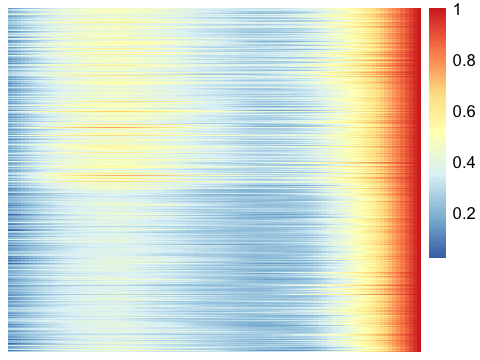

2  clusters  0.2367668 
3  clusters  0.2172323 
4  clusters  0.26844 
5  clusters  0.2227342 
6  clusters  0.2004026 
7  clusters  0.1822219 
8  clusters  0.1912851 
9  clusters  0.1882864 
10  clusters  0.1826218 

  1   2   3   4 
141 122  71  22 


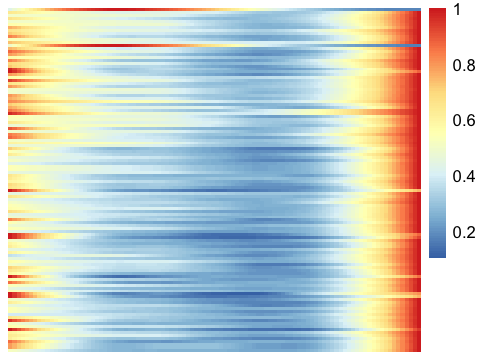

2  clusters  0.4925841 
3  clusters  0.2962027 
4  clusters  0.3624798 
5  clusters  0.2850684 
6  clusters  0.2551202 
7  clusters  0.2419508 
8  clusters  0.2301007 
9  clusters  0.2317802 
10  clusters  0.2397759 

  1   2 
 41 173 


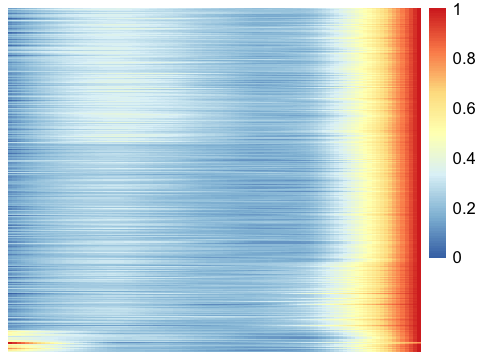

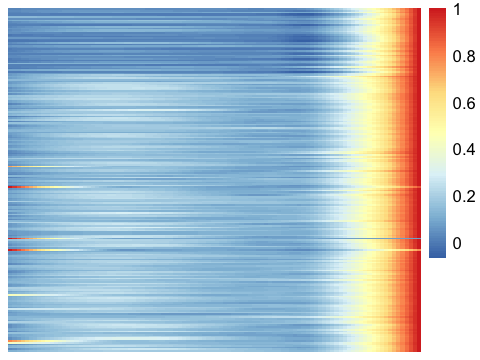

In [8]:
pk.scale.3 <- list(list(),list())
for(i in 1:2){
    for(j in 1:2){
    #cat(paste0("For Cluster ",i,"\n"))
    dat.sub.2.scale.2 <- dat.sub.2.scale.1[[i]][pk.scale.2[[i]]$pamobject$clustering==j,]
    pk.scale.3[[i]][[j]]<- pamk(dat.sub.2.scale.2,critout=T)
    print(table(pk.scale.3[[i]][[j]]$pamobject$clustering))
    pheatmap(dat.sub.2.scale.2[order(pk.scale.3[[i]][[j]]$pamobject$clustering),],
         border_color = NA,scale="none",cluster_rows = F,cluster_cols = F,
         show_rownames = F,show_colnames = F)
    }
}


In [9]:
# 
a=(pk.scale.3[[1]][[1]]$pamobject$clustering)
b1=ifelse(a==1,7,3)
names(b1)=names(a)

a=(pk.scale.3[[1]][[2]]$pamobject$clustering)
b2=ifelse(a==1,4,ifelse(a==2,1,ifelse(a==3,6,5)))
names(b2)=names(a)


a=(pk.scale.3[[2]][[1]]$pamobject$clustering)
b3=ifelse(a==1,8,2)
names(b3)=names(a)

a=(pk.scale.3[[2]][[2]]$pamobject$clustering)
b4=ifelse(a==1,10,9)
names(b4)=names(a)

final.ord = c(b1,b2,b3,b4)



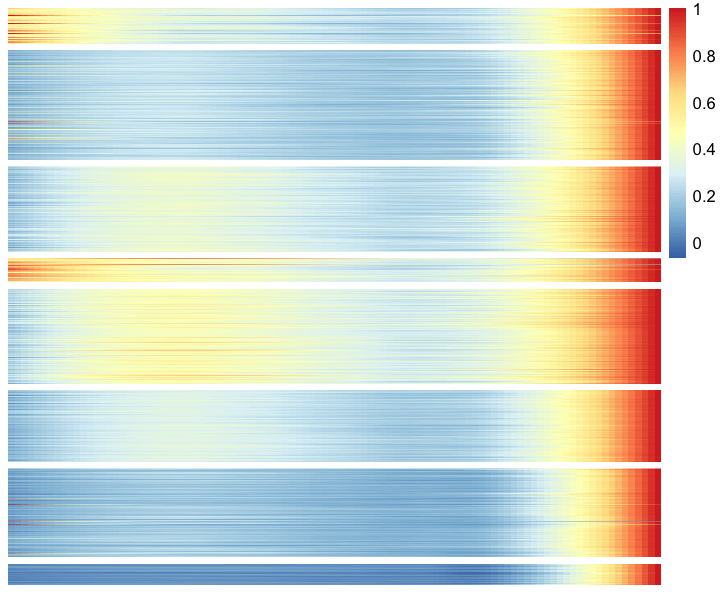

In [10]:
options(repr.plot.width=6, repr.plot.height=5)

pheatmap(dat.sub.2.scale[names(final.ord)[order(final.ord)],],
         gaps_row = as.numeric(cumsum(table(final.ord))),
         scale="none",cluster_rows = F,cluster_cols = F,
         show_rownames = F,show_colnames = F)

In [42]:
head(final.ord)

AAAS_28691   AAED1_127544 AASDHPPT_23418   ABCA1_127749   ABCB8_120111 
             7              7              3              7              3 
    ABCD3_5661 
             7

In [44]:
pk.list<-sapply(1:10,function(x)
        unique(unlist(sapply(names(which(final.ord==x)), function(y) 
            unlist(strsplit(y,split = "_"))[1]))))
str(pk.list)

## go enrich                             
require(enrichR)
dbs <- listEnrichrDbs()                 
pk.list.gene.enrichr <- lapply(pk.list,function(x) 
    enrichr(x, c("GO_Biological_Process_2018"))$GO_Biological_Process_2018)
                             

List of 10
 $ : chr [1:48] "ABCC8" "ABLIM2" "ACVR1" "ADCK1" ...
 $ : chr [1:259] "ACADVL" "ACSL1" "ADAM11" "ADK" ...
 $ : chr [1:519] "AASDHPPT" "ABCB8" "ABHD11" "AC020922.1" ...
 $ : chr [1:249] "AAMP" "AC007040.11" "AC024940.1" "AC026202.1" ...
 $ : chr [1:240] "ABHD17B" "ABI1" "ACSL3" "AHI1" ...
 $ : chr [1:269] "ABHD10" "ABHD12" "ABHD2" "ACAT2" ...
 $ : chr [1:1134] "AAAS" "AAED1" "ABCA1" "ABCD3" ...
 $ : chr [1:1286] "AAGAB" "AAMDC" "ABCA3" "ABCA5" ...
 $ : chr [1:754] "ABCB9" "ABCC10" "ABCF2" "ABCF3" ...
 $ : chr [1:390] "AATF" "ABHD2" "AC009403.2" "AC090616.2" ...


Loading required package: enrichR


Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2018... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2018... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2018... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2018... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2018... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2018... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2018... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2018... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2018... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  

In [45]:
for(i in 1:10){
    fn <- paste0("../dat/1901/dy.alpha.c",i,".enrichr.csv")
    fwrite(pk.list.gene.enrichr[[i]]%>%arrange(Adjusted.P.value),fn)
    system(paste0("open ",fn))
}
    

In [64]:
head(pk.list.gene.enrichr[[1]]%>%
    separate(Overlap,into = c("n.hit","n.tot"),sep = "/",remove = F,convert = T)%>%
    filter(n.tot<=100)%>%arrange(Adjusted.P.value))
head(pk.list.gene.enrichr[[2]]%>%
    separate(Overlap,into = c("n.hit","n.tot"),sep = "/",remove = F,convert = T)%>%
    filter(n.tot<=100)%>%arrange(Adjusted.P.value))
head(pk.list.gene.enrichr[[3]]%>%
    separate(Overlap,into = c("n.hit","n.tot"),sep = "/",remove = F,convert = T)%>%
    filter(n.tot<=100)%>%arrange(Adjusted.P.value))
head(pk.list.gene.enrichr[[4]]%>%
    separate(Overlap,into = c("n.hit","n.tot"),sep = "/",remove = F,convert = T)%>%
    filter(n.tot<=100)%>%arrange(Adjusted.P.value))
head(pk.list.gene.enrichr[[5]]%>%
    separate(Overlap,into = c("n.hit","n.tot"),sep = "/",remove = F,convert = T)%>%
    filter(n.tot<=100)%>%arrange(Adjusted.P.value))


Term,Overlap,n.hit,n.tot,P.value,Adjusted.P.value,Old.P.value,Old.Adjusted.P.value,Z.score,Combined.Score,Genes
regulation of insulin secretion (GO:0050796),5/99,5,99,3.882228e-06,0.000883207,4.764584e-06,0.001083943,-1.298500,16.17815,SLC30A8;ABCC8;GCG;GCK;SYT7
regulation of peptide hormone secretion (GO:0090276),4/74,4,74,2.969966e-05,0.004504449,3.604834e-05,0.005467332,-1.840800,19.18919,ABCC8;GCG;GCK;SYT7
positive regulation of insulin secretion (GO:0032024),3/32,3,32,6.127752e-05,0.006970318,8.049664e-05,0.009156493,-1.707040,16.55846,SLC30A8;GCG;GCK
regulation of gluconeogenesis (GO:0006111),2/20,2,20,1.042493e-03,0.094866898,1.274001e-03,0.115934108,-1.964166,13.48624,PPARGC1A;GCK
regulation of hormone biosynthetic process (GO:0046885),1/8,1,8,1.904280e-02,0.152921653,2.156860e-02,0.162513584,-4.019847,15.92288,STC2
regulation of toll-like receptor 9 signaling pathway (GO:0034163),1/8,1,8,1.904280e-02,0.152921653,2.156860e-02,0.162513584,-3.943933,15.62218,RSAD2


Term,Overlap,n.hit,n.tot,P.value,Adjusted.P.value,Old.P.value,Old.Adjusted.P.value,Z.score,Combined.Score,Genes
heterochromatin organization (GO:0070828),3/10,3,10,0.0002408423,0.1708776,0.0007377219,0.4964953,-2.489370,20.739861,HP1BP3;SNAI1;MTHFR
regulation of histone methylation (GO:0031060),3/13,3,13,0.0005577113,0.1978481,0.0013995640,0.4964953,-2.689010,20.145174,NSD1;MTHFR;ZNF335
positive regulation of protein ubiquitination (GO:0031398),6/84,6,84,0.0007781613,0.2208422,0.0018113471,0.5140603,-1.380327,9.881177,DCUN1D4;TBC1D7;SPRTN;UBE3A;BIRC2;PTK2
dendritic spine morphogenesis (GO:0060997),3/17,3,17,0.0012761782,0.2542796,0.0027318561,0.5347254,-2.452742,16.344791,ARC;DLG4;CTNND2
"nuclear-transcribed mRNA catabolic process, deadenylation-dependent decay (GO:0000288)",5/64,5,64,0.0014335707,0.2542796,0.0030279022,0.5347254,-1.819160,11.911106,PDE12;CNOT11;SAMD4A;EXOSC3;EIF4B
mannose metabolic process (GO:0006013),2/8,2,8,0.0044430063,0.2606304,0.0084620952,0.5347254,-3.312346,17.941073,MAN2A2;MAN2C1


Term,Overlap,n.hit,n.tot,P.value,Adjusted.P.value,Old.P.value,Old.Adjusted.P.value,Z.score,Combined.Score,Genes
microtubule nucleation (GO:0007020),4/18,4,18,0.0010194790,0.2782889,0.002435358,0.6581796,-2.560112,17.635237,RANBP9;TUBGCP3;CLASP1;CLASP2
autophagosome organization (GO:1905037),7/57,7,57,0.0006473757,0.2782889,0.001475324,0.6581796,-2.227811,16.357892,NSFL1C;GABARAPL1;TP53INP1;ULK3;ATG2A;PIK3C3;TRAPPC8
mRNA metabolic process (GO:0016071),9/98,9,98,0.0009994461,0.2782889,0.002147163,0.6581796,-1.675784,11.576831,CPSF6;SON;NCBP2;DHX15;HNRNPR;RNASE4;PRKACA;ZFP36L2;HNRNPA0
autophagosome assembly (GO:0000045),7/59,7,59,0.0007990556,0.2782889,0.001767899,0.6581796,-1.494110,10.656110,NSFL1C;GABARAPL1;TP53INP1;ULK3;ATG2A;PIK3C3;TRAPPC8
regulation of neurogenesis (GO:0050767),7/58,7,58,0.0007200610,0.2782889,0.001616468,0.6581796,-1.298849,9.398696,PER2;NUMB;CTNNB1;HOOK3;NREP;YWHAG;ARNTL
negative regulation of fat cell differentiation (GO:0045599),5/33,5,33,0.0014894893,0.3404973,0.003116763,0.6581796,-1.672045,10.883876,BBS12;AXIN1;RORA;ZFP36L2;ARNTL


Term,Overlap,n.hit,n.tot,P.value,Adjusted.P.value,Old.P.value,Old.Adjusted.P.value,Z.score,Combined.Score,Genes
snRNA modification (GO:0040031),2/7,2,7,0.003111100,0.3099943,0.005297455,0.4510331,-3.400353,19.62949,MRPL1;MEPCE
positive regulation of hormone metabolic process (GO:0032352),2/7,2,7,0.003111100,0.3099943,0.005297455,0.4510331,-3.291088,18.99872,PAX8;ARNT
snRNA metabolic process (GO:0016073),3/19,3,19,0.001594127,0.3099943,0.002495389,0.4510331,-2.397844,15.44554,INTS12;MEPCE;INTS9
protein kinase B signaling (GO:0043491),4/36,4,36,0.001010097,0.3099943,0.001528454,0.4510331,-1.979496,13.65399,CREB1;CDKN1B;MDM2;PTEN
morphogenesis of an epithelium (GO:0002009),3/20,3,20,0.001858304,0.3099943,0.002843478,0.4510331,-2.071675,13.02688,TRAF3IP1;MPP5;VCL
cellular response to unfolded protein (GO:0034620),3/23,3,23,0.002808557,0.3099943,0.004061258,0.4510331,-2.048753,12.03660,PACRG;HSPH1;HSPA13


Term,Overlap,n.hit,n.tot,P.value,Adjusted.P.value,Old.P.value,Old.Adjusted.P.value,Z.score,Combined.Score,Genes
negative regulation of double-strand break repair via homologous recombination (GO:2000042),3/9,3,9,0.0001358962,0.04970405,0.0003548833,0.1297986,-2.648192,23.57849,HELB;FBXO18;POLK
negative regulation of potassium ion transport (GO:0043267),3/12,3,12,0.0003465484,0.09771464,0.0007145733,0.1742368,-2.246998,17.90293,NANOS1;PTK2B;NEDD4L
negative regulation of DNA recombination (GO:0045910),3/17,3,17,0.0010246675,0.17480817,0.0017123998,0.2543040,-2.144858,14.76389,HELB;FBXO18;POLK
negative regulation of double-strand break repair (GO:2000780),3/20,3,20,0.0016728054,0.17480817,0.0025902665,0.2561212,-2.281937,14.58900,HELB;FBXO18;POLK
regulation of stress-activated MAPK cascade (GO:0032872),4/42,4,42,0.0015826903,0.17480817,0.0022852627,0.2561212,-1.887746,12.17337,PHLPP1;COPS5;PDCD10;FOXO1
DNA conformation change (GO:0071103),3/19,3,19,0.0014345200,0.17480817,0.0022724928,0.2561212,-1.544353,10.11076,TOP2B;KAT6A;HMGB2


In [65]:
head(pk.list.gene.enrichr[[6]]%>%
    separate(Overlap,into = c("n.hit","n.tot"),sep = "/",remove = F,convert = T)%>%
    filter(n.tot<=100)%>%arrange(Adjusted.P.value))
head(pk.list.gene.enrichr[[7]]%>%
    separate(Overlap,into = c("n.hit","n.tot"),sep = "/",remove = F,convert = T)%>%
    filter(n.tot<=100)%>%arrange(Adjusted.P.value))
head(pk.list.gene.enrichr[[8]]%>%
    separate(Overlap,into = c("n.hit","n.tot"),sep = "/",remove = F,convert = T)%>%
    filter(n.tot<=100)%>%arrange(Adjusted.P.value))
head(pk.list.gene.enrichr[[9]]%>%
    separate(Overlap,into = c("n.hit","n.tot"),sep = "/",remove = F,convert = T)%>%
    filter(n.tot<=100)%>%arrange(Adjusted.P.value))
head(pk.list.gene.enrichr[[10]]%>%
    separate(Overlap,into = c("n.hit","n.tot"),sep = "/",remove = F,convert = T)%>%
    filter(n.tot<=100)%>%arrange(Adjusted.P.value))


Term,Overlap,n.hit,n.tot,P.value,Adjusted.P.value,Old.P.value,Old.Adjusted.P.value,Z.score,Combined.Score,Genes
response to unfolded protein (GO:0006986),7/44,7,44,1.844717e-06,0.002743095,5.402417e-06,0.008033394,-1.571419,20.74774,HSPA1L;RHBDD1;HSPB1;HSPE1;HSPD1;HERPUD1;HSPA1A
regulation of endoplasmic reticulum stress-induced intrinsic apoptotic signaling pathway (GO:1902235),4/21,4,21,1.599266e-04,0.118905464,3.356627e-04,0.249565182,-2.091948,18.28529,BCL2L11;EIF2AK3;HERPUD1;HSPA1A
Rap protein signal transduction (GO:0032486),3/11,3,11,3.665214e-04,0.181672431,8.075490e-04,0.347389353,-2.515696,19.90281,RAP1B;RAP2B;RAPGEF2
'de novo' posttranslational protein folding (GO:0051084),4/31,4,31,7.565037e-04,0.224984205,1.249493e-03,0.371599261,-1.624908,11.67790,CCT2;HSPA1L;HSPE1;HSPA1A
positive regulation of RNA metabolic process (GO:0051254),4/36,4,36,1.343613e-03,0.314239541,2.068562e-03,0.469867033,-1.670435,11.04557,DYRK1A;HABP4;WDR75;HSPA1A
chaperone-mediated protein complex assembly (GO:0051131),3/18,3,18,1.690596e-03,0.314239541,2.750997e-03,0.469867033,-1.680777,10.72785,CCT2;HSPD1;HSPA1A


Term,Overlap,n.hit,n.tot,P.value,Adjusted.P.value,Old.P.value,Old.Adjusted.P.value,Z.score,Combined.Score,Genes
peptidyl-threonine dephosphorylation (GO:0035970),8/17,8,17,1.589212e-06,0.0006463686,4.440671e-05,0.01493398,-2.231230,29.79200,PPP2CA;PDP1;DUSP4;DUSP5;PPM1B;DUSP10;DUSP1;PPP1CA
peptidyl-tyrosine dephosphorylation (GO:0035335),9/26,9,26,7.564375e-06,0.0021004675,1.011519e-04,0.02834781,-2.413608,28.46141,DUSP4;DUSP5;DUSP10;DUSP1;DUSP28;PTPRJ;PTPN12;PTPN13;PTPN2
transforming growth factor beta receptor signaling pathway (GO:0007179),14/77,14,77,9.517505e-05,0.0160036843,5.325643e-04,0.09426387,-1.458248,13.50307,SMAD2;SMAD1;JUN;SMAD4;FOS;CBL;PRKCZ;SIRT1;RHOA;TGFBR2;DUSP22;UBC;UBA52;BMPR1A
positive regulation of cellular amide metabolic process (GO:0034250),12/62,12,62,1.599094e-04,0.0185439757,8.085362e-04,0.10451304,-2.090969,18.27696,FXR1;SMPD2;DDX3X;ROCK2;HNRNPD;RPL26;LARP4B;PASK;LARP4;CPEB3;CLU;PICALM
axonal transport (GO:0098930),9/37,9,37,1.713117e-04,0.0192040441,9.054242e-04,0.10451304,-1.557755,13.50889,FXR1;BLOC1S6;AP3D1;DTNBP1;AP3S1;TRAK1;AP3B2;HIF1A;TRAK2
positive regulation of cellular protein metabolic process (GO:0032270),15/92,15,92,1.946853e-04,0.0209332591,9.323197e-04,0.10451304,-1.428705,12.20704,CYFIP2;DDX3X;NR1H2;LARP4B;PASK;LARP4;FXR1;NFKBIA;ASPH;HNRNPD;VPS35;RPL26;EZR;CPEB3;BTRC


Term,Overlap,n.hit,n.tot,P.value,Adjusted.P.value,Old.P.value,Old.Adjusted.P.value,Z.score,Combined.Score,Genes
regulation of cytokinesis (GO:0032465),17/78,17,78,7.317061e-06,0.006265233,7.639227e-05,0.06541088,-2.239721,26.48538,PLK3;AHCTF1;PRKCE;VPS4A;KLHL21;PDXP;MYO19;RAB11A;CDC42;FLCN;SPAST;KIF13A;PIN1;BIRC6;CALM2;RAB11FIP4;GIT1
regulation of cell division (GO:0051302),14/66,14,66,6.336440e-05,0.024113676,4.075289e-04,0.15795896,-2.278730,22.02759,PLK3;AHCTF1;KLHL21;PDXP;MYO19;RAB11A;FLCN;KIF13A;CDK2AP2;PIN1;BIRC6;CALM2;RAB11FIP4;GIT1
negative regulation of response to endoplasmic reticulum stress (GO:1903573),8/23,8,23,5.864509e-05,0.024113676,4.992976e-04,0.15795896,-1.950476,19.00545,DNAJC3;PPP1R15B;CREB3;USP25;XBP1;SYVN1;TMBIM6;NCK1
nose development (GO:0043584),5/9,5,9,1.104540e-04,0.031525400,1.189257e-03,0.19865248,-3.214291,29.28512,SKI;SMCHD1;CHD7;PROX1;GLI3
negative regulation of G2/M transition of mitotic cell cycle (GO:0010972),13/63,13,63,1.544404e-04,0.037782745,8.117324e-04,0.19865248,-1.956789,17.17220,PSMD11;VPS4A;PINX1;RBX1;PSMA5;PSMD9;PSMD7;PSMC3;PSMA1;PSMC2;UBC;PSMD1;SKP1
regulation of cell cycle process (GO:0010564),16/91,16,91,2.072959e-04,0.039443811,9.935009e-04,0.19865248,-1.539678,13.05857,PLK3;AHCTF1;TIPIN;SPAG5;KLHL21;PDXP;MYO19;RAB11A;CDC42;FLCN;KIF13A;PIN1;BIRC6;CALM2;RAB11FIP4;GIT1


Term,Overlap,n.hit,n.tot,P.value,Adjusted.P.value,Old.P.value,Old.Adjusted.P.value,Z.score,Combined.Score,Genes
snRNA metabolic process (GO:0016073),5/19,5,19,0.0005623200,0.1183215,0.001570104,0.3303761,-2.389089,17.878603,INTS1;SNAPC2;INTS2;TUT1;INTS7
regulation of hippo signaling (GO:0035330),4/12,4,12,0.0007785165,0.1512119,0.002312867,0.3531976,-2.848454,20.389578,NEK8;DLG5;WWC3;NF2
"alternative mRNA splicing, via spliceosome (GO:0000380)",4/13,4,13,0.0010911265,0.1763821,0.002937485,0.3531976,-2.471855,16.859398,DDX17;HNRNPM;SFPQ;SRSF1
positive regulation of histone acetylation (GO:0035066),5/22,5,22,0.0011594616,0.1763821,0.002723170,0.3531976,-1.946310,13.156665,TADA2B;SMAD4;TADA2A;KAT7;PPARGC1A
negative regulation of type I interferon production (GO:0032480),7/45,7,45,0.0013693798,0.1819834,0.002786355,0.3531976,-1.470649,9.696570,RNF135;MAVS;ITCH;RNF216;TRAF3;CACTIN;RELB
protein ubiquitination involved in ubiquitin-dependent protein catabolic process (GO:0042787),9/71,9,71,0.0013499370,0.1819834,0.002619473,0.3531976,-1.263171,8.346655,ITCH;MAEA;UBE3C;ARIH2;SPOP;FBXO45;BTBD9;RNF5;ANAPC2


Term,Overlap,n.hit,n.tot,P.value,Adjusted.P.value,Old.P.value,Old.Adjusted.P.value,Z.score,Combined.Score,Genes
regulation of hematopoietic progenitor cell differentiation (GO:1901532),9/78,9,78,2.068818e-05,0.01252325,5.134913e-05,0.03108334,-2.327957,25.10923,PSMA3;YTHDF2;UBB;KMT2A;PSMB3;PSME3;PSMD3;PSMF1;PSMA7
regulation of hematopoietic stem cell differentiation (GO:1902036),9/77,9,77,1.861719e-05,0.01252325,4.683090e-05,0.03108334,-1.391143,15.15153,PSMA3;YTHDF2;UBB;KMT2A;PSMB3;PSME3;PSMD3;PSMF1;PSMA7
SCF-dependent proteasomal ubiquitin-dependent protein catabolic process (GO:0031146),9/73,9,73,1.199830e-05,0.01252325,3.195681e-05,0.03108334,-1.318821,14.94322,FBXL20;PSMA3;UBB;PSMB3;PSME3;PSMD3;PSMF1;PSMA7;FBXO31
regulation of stem cell differentiation (GO:2000736),9/89,9,89,5.973914e-05,0.02712157,1.305610e-04,0.05419470,-1.937209,18.84037,PSMA3;YTHDF2;UBB;KMT2A;PSMB3;PSME3;PSMD3;PSMF1;PSMA7
cellular response to nitrogen levels (GO:0043562),4/14,4,14,1.220672e-04,0.02737824,3.581148e-04,0.05419470,-2.374910,21.40017,BECN1;MAP1LC3B;MAP1LC3A;GABARAP
signal transduction in response to DNA damage (GO:0042770),5/26,5,26,1.289507e-04,0.02737824,3.147610e-04,0.05419470,-2.047062,18.33365,PAXIP1;USP10;SESN2;GRB2;TRIAP1


In [55]:
head(pk.list.gene.enrichr[[6]]%>%arrange(Adjusted.P.value)%>%
    separate(Overlap,into = c("n.hit","n.tot"),sep = "/",remove = F)%>%
    filter(n.tot<=100))


Term,Overlap,n.hit,n.tot,P.value,Adjusted.P.value,Old.P.value,Old.Adjusted.P.value,Z.score,Combined.Score,Genes
